# Проект: классификация

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn import linear_model, tree, ensemble, metrics, preprocessing, model_selection
import warnings
warnings.filterwarnings('ignore')

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

Загрузим данные и посмотрим на них

In [2]:
df = pd.read_csv('data/bank_fin.zip', sep = ';', compression='zip')
print(df.shape)
df.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
# Выведем информацию о колонках
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


## Состав датасета

### Данные о клиентах банка:

  * age (возраст);
  * job (сфера занятости);
  * marital (семейное положение);
  * education (уровень образования);
  * default (имеется ли просроченный кредит);
  * housing (имеется ли кредит на жильё);
  * loan (имеется ли кредит на личные нужды);
  * balance (баланс).

### Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

  * contact (тип контакта с клиентом);
  * month (месяц, в котором был последний контакт);
  * day (день, в который был последний контакт);
  * duration (продолжительность контакта в секундах).
    
### Прочие признаки:

  * campaign (количество контактов с этим клиентом в течение текущей кампании);
  * pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
  * previous (количество контактов до текущей кампании)
  * poutcome (результат прошлой маркетинговой кампании).

### Целевой признак:

  * deposit

Посмотрим есть ли дубликаты в данных

In [4]:
df.duplicated().sum()

0

Как видно - нет. Теперь посчитаем количество пропусков в каждой колонке

In [5]:
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Значения None есть только в колонке balance, однако при более внимательном исследовании можно заметить, что в колонках job и education тоже есть пропуски, которые заполнены значением unknown, посмотрим какие есть значения в этих колонках:

In [6]:
print(df['job'].value_counts())
print()
print(df['education'].value_counts())

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64


Прежде чем работать с пропусками, следует исправить один момент: признак balance, который, исходя из названия, должен быть числовым, но имеет тип данных object. Преобразуем его к типу float.

In [7]:
# Уберем ненужные символы и пробелы, затем изменим тип данных
df['balance'] = df['balance'].str.replace(',', '.').str.replace(' ', '').str.replace('$', '')
df['balance'] = df['balance'].astype(float)
df['balance'].head() 

0    2343.0
1      45.0
2    1270.0
3    2476.0
4     184.0
Name: balance, dtype: float64

Теперь можно заполнить пропуски. Заполним пропуски в колонке balance медианой, а пропуски в категориальных признаках job и education модой:

In [8]:
df['balance'] = df['balance'].fillna(df['balance'].median())
df['job'] = df['job'].replace('unknown', df['job'].value_counts().index[0])
df['education'] = df['education'].replace('unknown', df['education'].value_counts().index[0])

Теперь можно проверить числовые признаки на предмет выбросов:

In [9]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1526.936033,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3224.829691,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,123.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1699.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


В глаза явно бросается признак balance, тут явно присутствуют выбросы, которые могут отрицательно сказаться на качестве нашей модели, поэтому я думаю следует их удалить. Признаки duration, campaign, pdays и previous
тоже имеют выбросы, но с ними я думаю следует разобраться чуть позже.

Для того чтобы избавиться от выбросов прекрасно подойдет метод Тьюки. Согласно данному методу, выбросы находятся за пределами отрезка, нижняя граница которого определяется как первый квартиль (0.25), из которого вычли полтора межквартильных размаха, а верхняя граница — как третий квартиль (0.75), к которому прибавили полтора межквартильных размаха. Пропишем это в коде:

In [10]:
# Определяем квартили
quartile_1 = df['balance'].quantile(0.25)
quartile_3 = df['balance'].quantile(0.75)
# Межквартильный размах
iqr = quartile_3 - quartile_1
# Верхнюю и нижнюю границу
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
# Посчитаем количество выбросов и удалим их
outliers = df[(df['balance'] < lower_bound) | (df['balance'] > upper_bound)]
df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

print(f'Количество выбросов: {outliers.shape[0]}')
print(f'Размер датасета после удаления выбросов: {df.shape}') 

Количество выбросов: 1057
Размер датасета после удаления выбросов: (10105, 17)


## Часть 2:  Разведывательный анализ

Изучим соотношение классов целевой переменной на предмет несбалансированности

In [11]:
px.pie(data_frame=df, 
       names='deposit',
       height=400,
       width=600,
       title='Соотношение классов признака deposit',
       hole=0.4
       )

Как видим на диаграмме, классы достаточно сбалансированы, разница примерно 6%. 

Теперь проведем визуальный анализ числовых переменных:

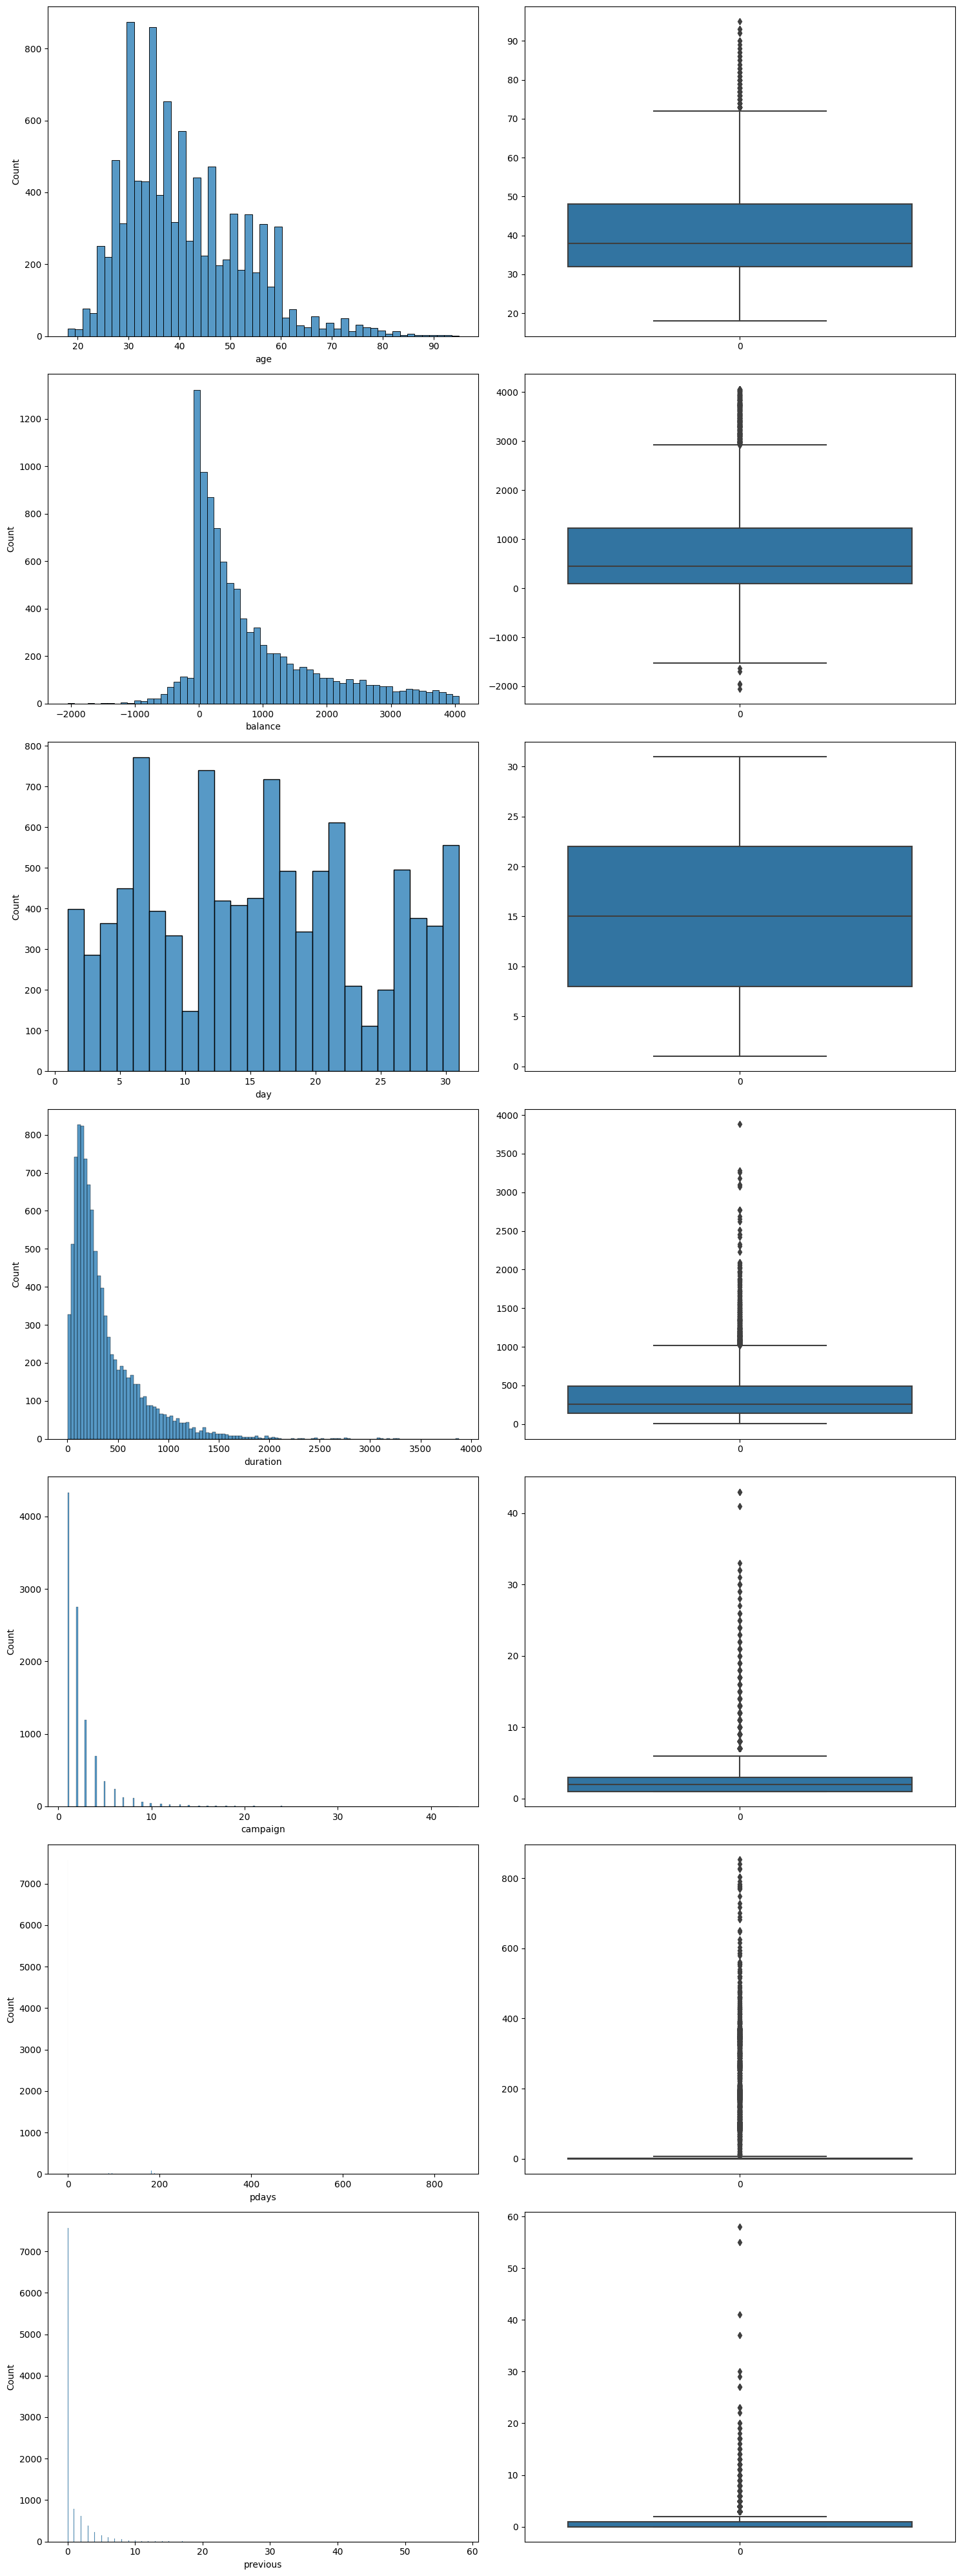

In [12]:
# Создадим список из числовых признаков
num_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Зададим пространство 
fig, axes = plt.subplots(len(num_features), 2, figsize=(15, 40)) 

# Напишем функцию, которая будет строить гистограмму и коробчатую диаграмму для каждого признака 
for i, feature in enumerate(num_features):
    hist = sns.histplot(df[feature], ax=axes[i][0])
    boxplot = sns.boxplot(df[feature], ax=axes[i][1])
plt.tight_layout()

На всех графиках коробчатые диаграммы показывают выбросы. Это потому что при построении графиков подразумевается что мы передаем для них нормально распределенные данные, но среди всех числовых данных только признаки age и balance по своей природе могут иметь нормальное распределение. Поэтому не будем слишком строги к данным и удалим только аномальные значения, которые сильно выбиваются из общей картины. 

В признаках duration, campaign, previous присутствуют значения, которые находятся далеко от своих соседей на коробчатых диаграммах, эти значения я думаю можно удалить.

In [13]:
len0 = df.shape[0]
df = df[df['duration'] < 2800]
df = df[df['campaign'] <= 33]
df = df[df['previous'] <= 30]
f'Удалено {len0 - df.shape[0]} строк, размер датасета сейчас {df.shape}'

'Удалено 14 строк, размер датасета сейчас (10091, 17)'

Теперь можем заняться категориальными признаками. Для более удобной визуализации приведем наш целевой признак к булевому типу:

In [14]:
df['deposit'] = df['deposit'] == 'yes'

Перед тем как строить визуализацию для категориальных признаков думаю следует создать еще несколько таких признаков, отражающих возрастную группу, размер баланса и длительность разговора, чтобы посмотреть на то, как они влияют на целевую переменную. После визуализации можно удалить эти признаки, так как они фактически дублируют числовые признаки, из которых были созданы.

In [15]:
# Проведем разделение числовых значений на группы
df['age_group'] = pd.cut(df['age'], 
                        bins = [0, 29, 39, 49, 60, 100],
                        labels=['< 30', '30-39', '40-49', '50-59', '60+']
                        ).astype(object)
df['balance_group'] = pd.cut(df['balance'], 
                        bins = [-5000, 0, 1000, 2000, 5000],
                        labels=['negative', 'small', 'medium', 'large']
                        ).astype(object)
df['duration_group'] = pd.cut(df['duration'], 
                        bins = [0, 200, 500, 1000, 5000],
                        labels=['quick', 'short', 'medium', 'long']
                        ).astype(object)

Теперь мы можем визуализировать долю открытых депозитов для каждого категориального признака, т.е. узнать как влияет каждый категориальный признак на целевую переменную. Для этого построим для каждого признака по два графика: 

  * на первом изобразим количество вхождений для каждой категории нашего признака;
  * на втором изобразим долю открывших депозит для каждого класса.

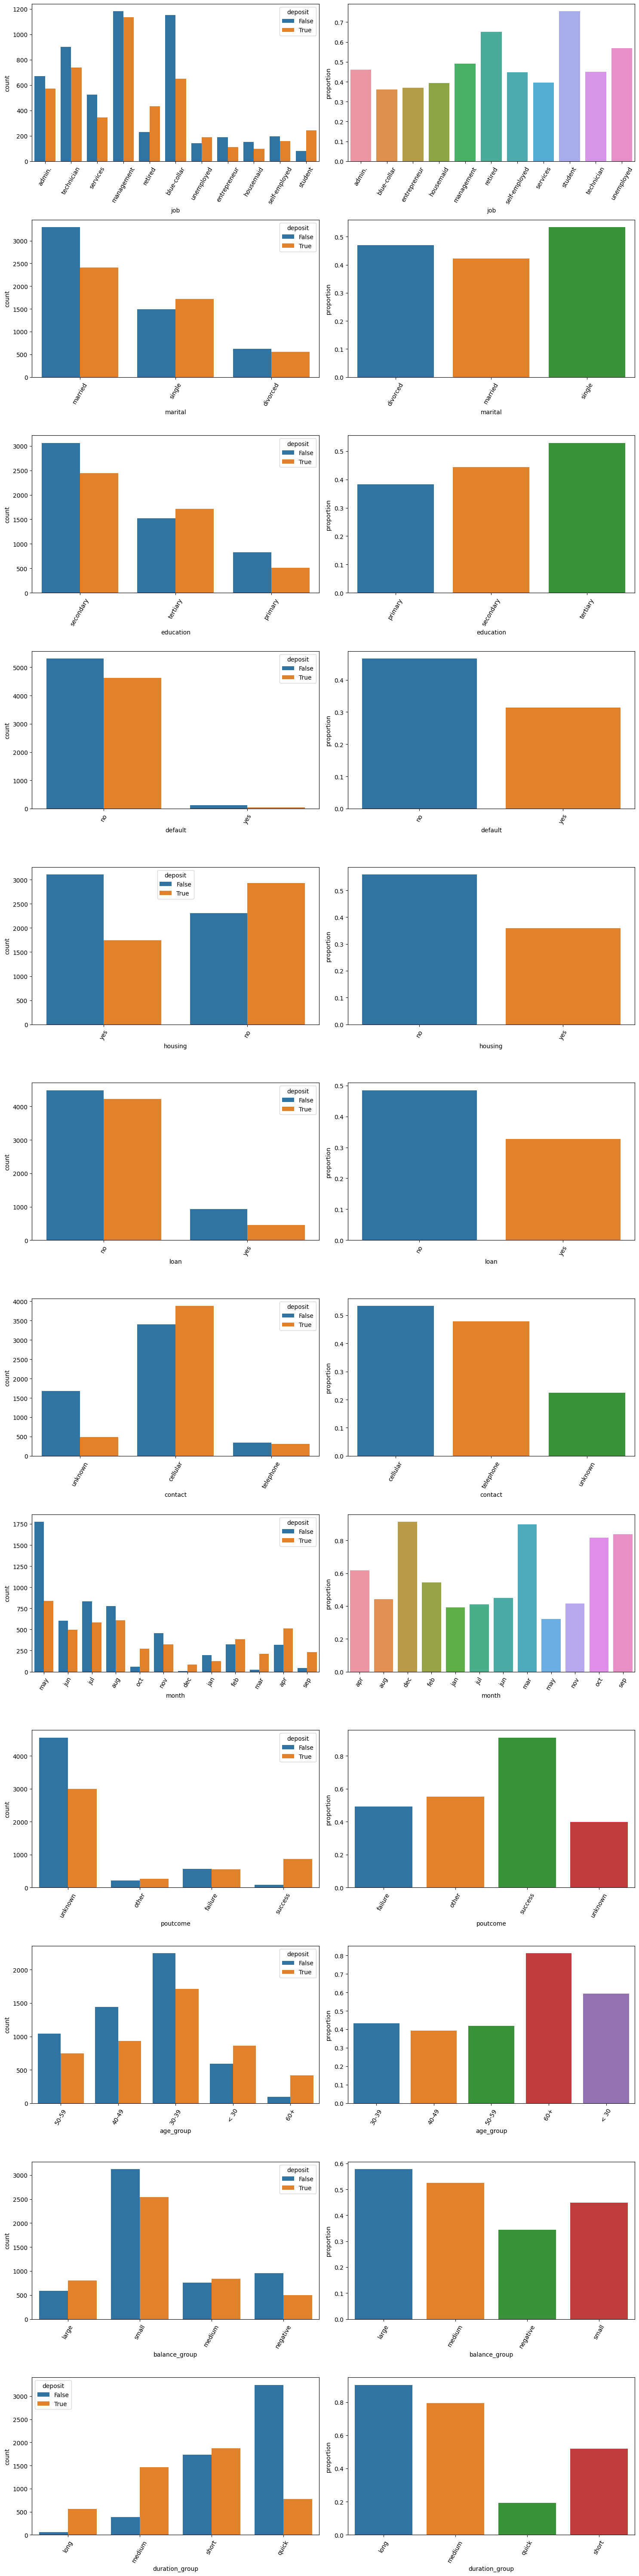

In [16]:
# Создадим список из катогориальных признаков
cat_features = list(df.dtypes[df.dtypes == 'object'].index)
# Зададим пространство
fig, axes = plt.subplots(len(cat_features), 2, figsize=(15, 60))
# Создаем цикл для всех признаков из списка
for i, feature in enumerate(cat_features):
    # Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    countplot = sns.countplot(data=df, x=feature, hue='deposit', ax=axes[i][0])
    countplot.xaxis.set_tick_params(rotation=60)
    # Строим столбчатую диаграмму для отображения доли клиентов, открывших депозит для каждой категории
    bar_data = df.groupby(feature)['deposit'].mean().reset_index().rename(columns={'deposit': 'proportion'})
    barplot = sns.barplot(data=bar_data, x=feature, y='proportion', ax=axes[i][1])
    barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков 

### Можно сделать промежуточные выводы:

  * Чем дольше разговор с клиентом, тем более вероятно открытие депозита, корреляция достаточно сильная;
  * Чем больше баланс клиента, тем вероятнее открытие депозита, корреляция несильная;
  * Только среди самой младшей и самой старшей возрастной группы количество открытых депозитов больше вероятности 0.5, однако эти группы являются наиболее малочисленными;
  * Если предыдущая рекламная кампания закончилась успешно, то очень высока вероятность успеха и в текущей кампании, в то же время если предыдущая кампания не увенчалась успехом, то шансы на успех в текущей не такие уж и плохие - примерно 50/50;
  * Есть откровенно успешные и неудачные месяца по показателю открытых депозитов;
  * Вид контакта не особо влияет на результат. Учитывая большой дисбаланс классов этого признака, думаю что он не принесет пользы;
  * Клиенты без обременений и без просрочек по кредитам охотнее открывают депозит;
  * Чем выше уровень образования, тем охотнее открывают депозит;
  * Семейное положение несильно влияет на решение открыть депозит, но у одиноких людей доля открытых депозитов чуть выше;
  * Сфера деятельности влияет на вероятность открытия депозита, что удивительно она наиболее высокая у классов student и retired, т.е. скорее всего безработных людей

## Часть 3: преобразование данных

Для начала преобразуем бинарные признаки в числовой вид:

In [17]:
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)
df['deposit'] = df['deposit'].astype(int)

У нас есть признаки, которые мы создавали только для визуализации: age_group, balance_group и duration_group, удалим их.

In [18]:
df = df.drop(['age_group', 'duration_group', 'balance_group'], axis=1)

Среди категориальных признаков есть как порядковые, так и номинальные, кодировать их будем разными способами.Закодируем сначала порядковый признак education при помощи OrdinalEncoder:

In [19]:
# Создаем энкодер, указывая порядок значений, для корректного кодирования, затем преобразуем признак
encoder = preprocessing.OrdinalEncoder(categories=[['primary', 'secondary', 'tertiary']])
df['education'] = encoder.fit_transform(df['education'].to_frame())

Теперь создадим дамми-переменные для столбцов с номинальными признаками.

In [20]:
df = pd.get_dummies(data=df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])
df.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1.0,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,56,1.0,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,41,1.0,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,55,1.0,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,54,2.0,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1


У нас получилось 45 колонок. Теперь построим корреляционную матрицу, и исследуем ее на предмет мультиколлениарности:

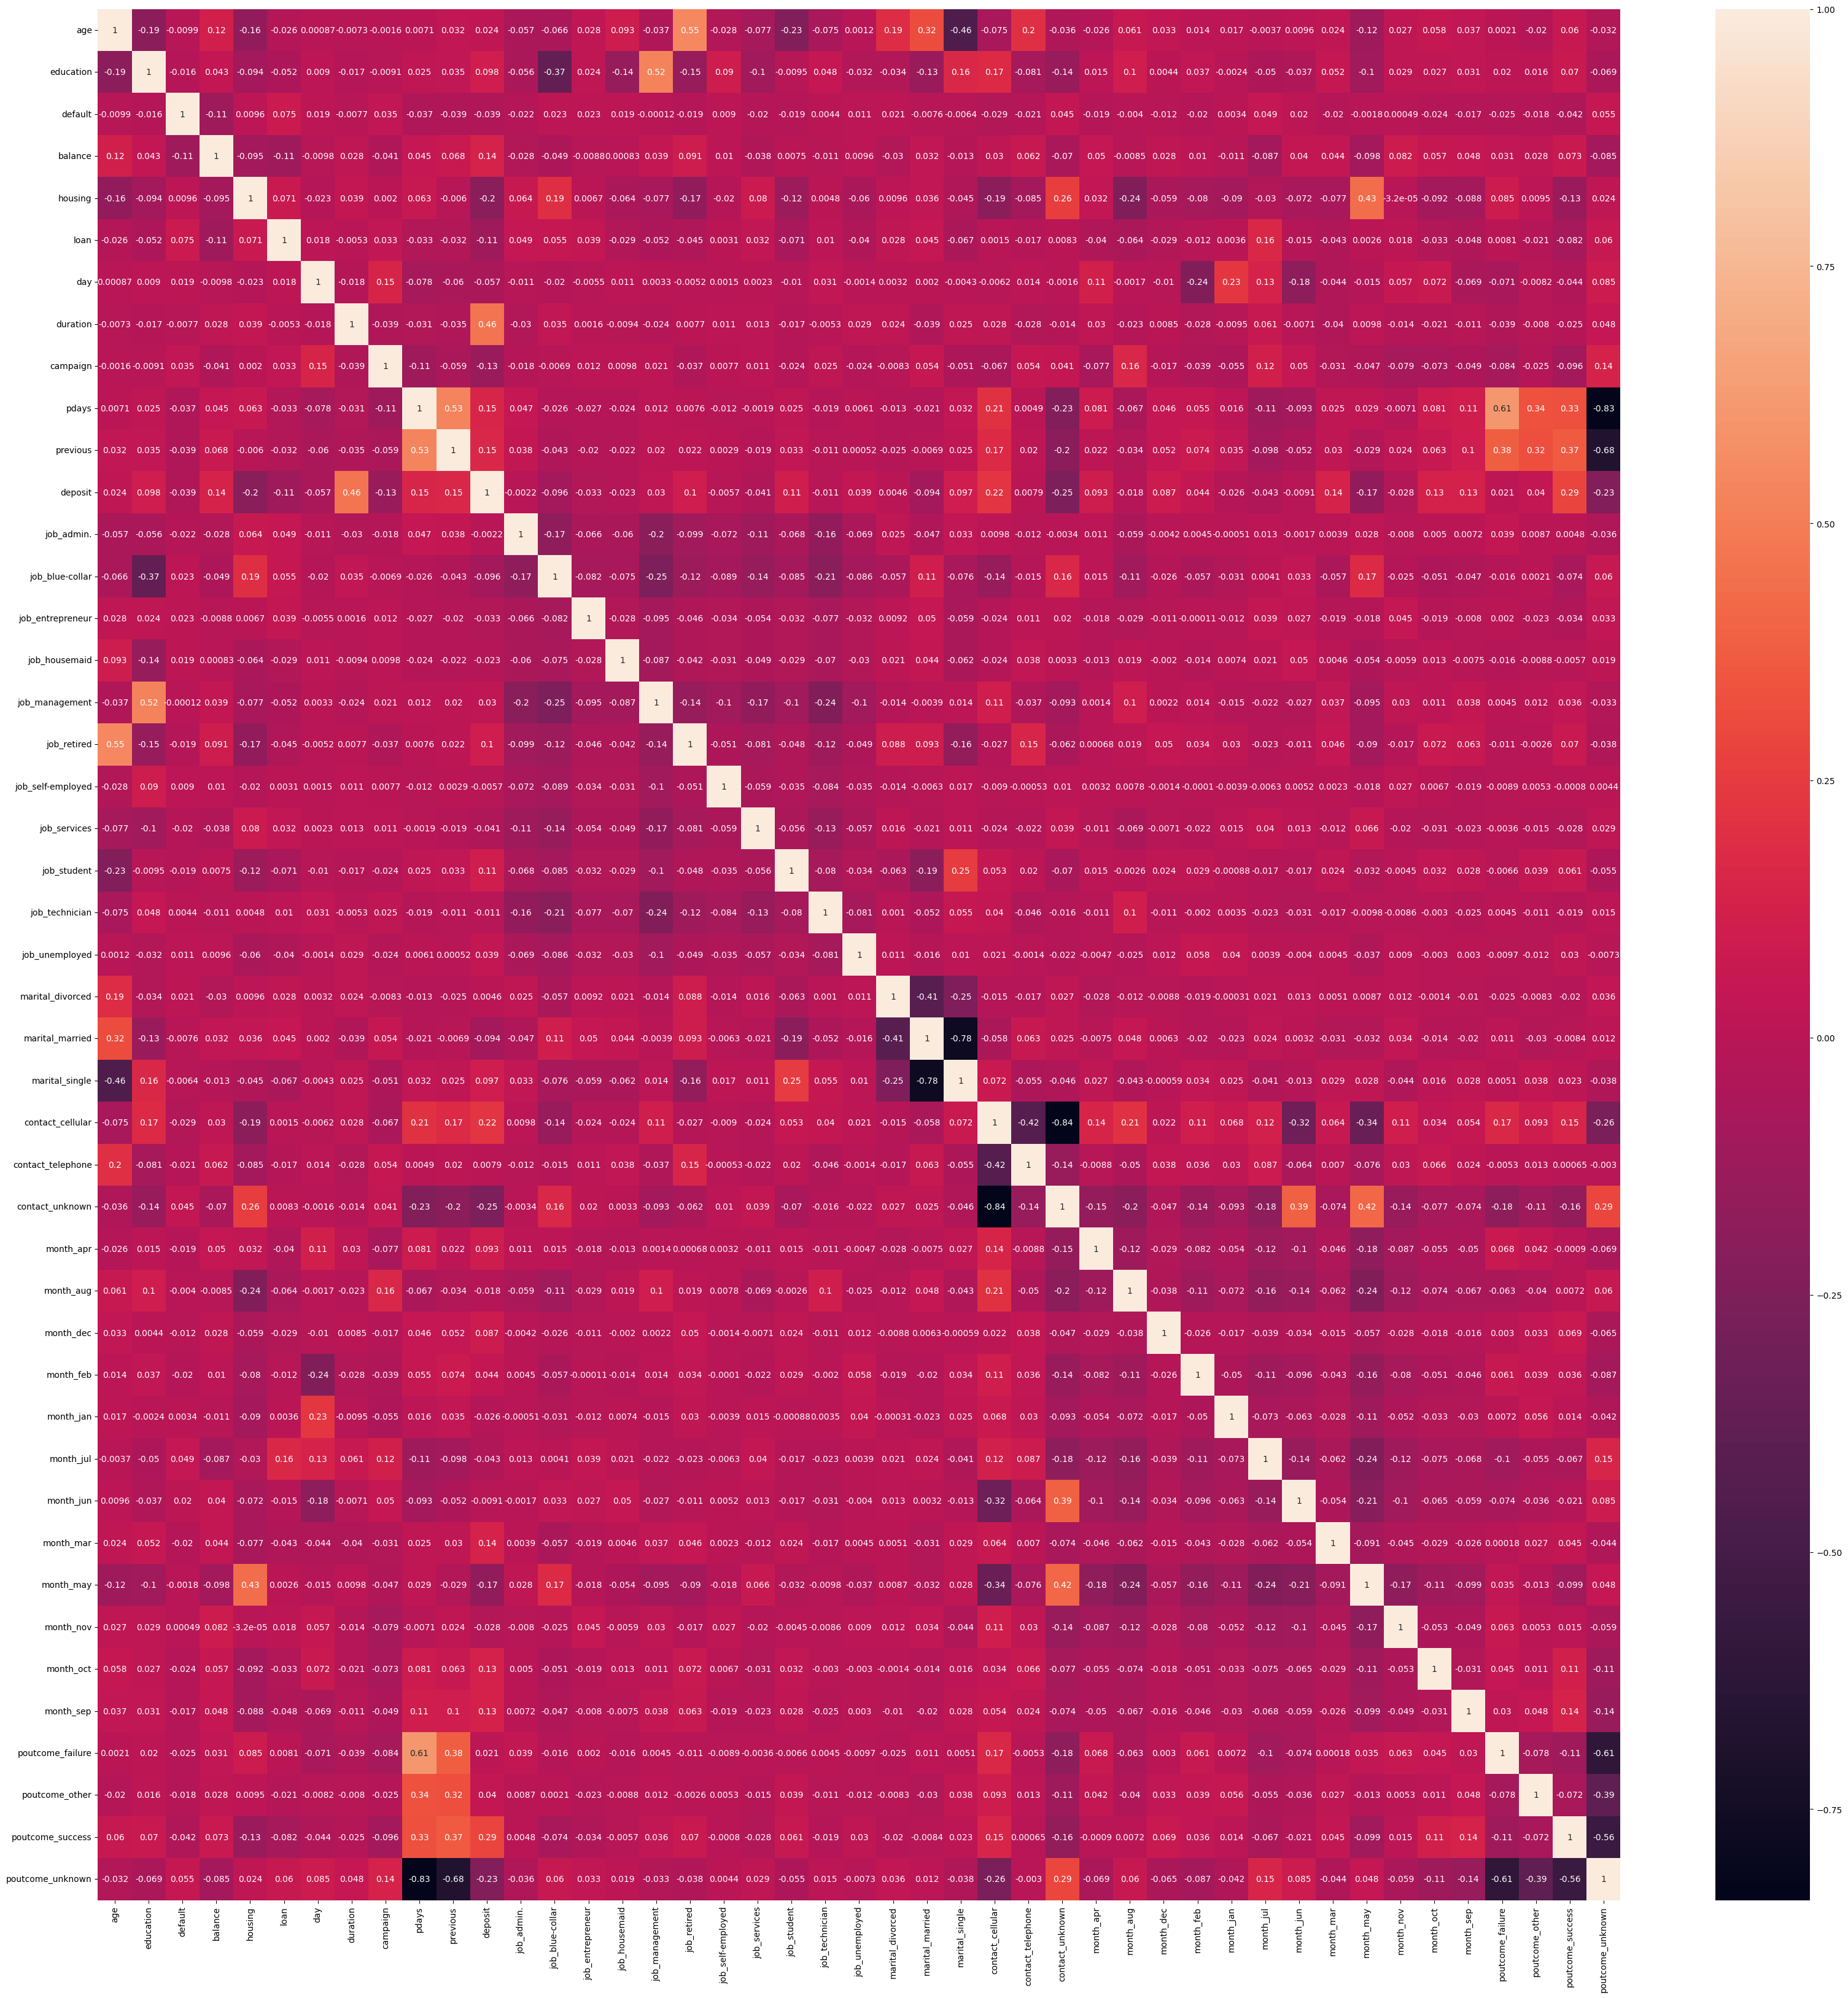

In [21]:
plt.figure(figsize=(40, 40))
sns.heatmap(df.corr(), annot=True);

Что бросается в глаза, это то что признак poutcome_unknown имеет большую корреляцию со многими другими признаками, его точно следует удалить. Также есть 2 пары скоррелированных между собой признаков: contact_cellular и contact_unknown, marital_married и marital_single. В каждой из этих пар нужно удалить по одному признаку. Чтобы определить какие из них удалить, построим еще один график, который отображает корреляцию с целевым признаком duration.

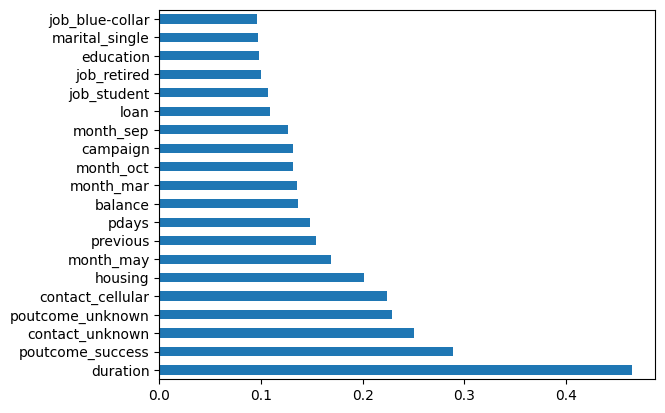

In [22]:
df.corrwith(df['deposit']).apply(lambda x: abs(x)).sort_values(ascending=False)[1:21].plot.barh();

Исходя из этого графика можно сделать вывод, какие признаки можно удалить в скоррелированных парах. В каждой паре это те признаки, которые имеют меньшую корреляцию с целевым признаком: contact_cellular, marital_married. После их удаления останется 12 признаков, которые, судя по графику, имеют наибольшую значимость.

In [23]:
df = df.drop(['poutcome_unknown', 'contact_cellular', 'marital_married'], axis=1)

Теперь отберем 12 лучших признаков с помощью специального класса и сравним с тем, что мы получили при помощи визуализации

In [24]:
from sklearn.feature_selection import SelectKBest, f_classif

# Выделим матрицу наблюдений и таргет 
X = df.drop(['deposit'], axis=1)
y = df['deposit']
# Создадим селектор и обучим его
selector = SelectKBest(score_func=f_classif, k=12)
selector.fit(X, y)
# Выведем лучшие признаки 
best = selector.get_feature_names_out()
best

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'contact_unknown', 'month_mar', 'month_may', 'month_oct',
       'month_sep', 'poutcome_success'], dtype=object)

Данный способ выдал те же признаки, что и при визуализации корреляций, поэтому преобразуем матрицу, оставив 12 признаков:

In [25]:
X = X[best]

Разделим датасет на тренировочную и тестовую выборки.

In [26]:
from sklearn.model_selection import train_test_split 
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.3)

Теперь нужно нормализовать данные, сделаем это при помощи minmaxsxaler:

In [27]:
# Сохраним названия колонок
cols = X.columns

# Создадим объект класса MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# Проведем нормализацию
X_train = pd.DataFrame(mm_scaler.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(mm_scaler.transform(X_test), columns=cols)
X = pd.DataFrame(mm_scaler.fit_transform(X), columns=cols)

# Часть 4: Логистическая регрессия и решающие деревья

In [28]:
# Напишем функцию, которая будет выводить метрики
def print_metrics(y_pred_tr, y_pred_te):
    print(f'Accuracy на тренировочной выборке: {np.round(metrics.accuracy_score(y_train, y_pred_tr), 3)}')
    print(f'Accuracy на тестовой выборке: {np.round(metrics.accuracy_score(y_test, y_pred_te), 3)}')
    print(f'f1-score на тренировочной выборке: {np.round(metrics.f1_score(y_train, y_pred_tr), 3)}')
    print(f'f1-score на тестовой выборке: {np.round(metrics.f1_score(y_test, y_pred_te), 3)}')

Начнем с простых моделей. Посмотрим какой результат выдаст модель логистическая регрессия на стандартных настройках без кросс-валидации.

In [29]:
# Создаем модель и обучаем ее
lr = linear_model.LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Делаем предсказания
y_pred_tr = lr.predict(X_train)
y_pred_te = lr.predict(X_test)

# Выводим метрики
print_metrics(y_pred_tr, y_pred_te)

Accuracy на тренировочной выборке: 0.817
Accuracy на тестовой выборке: 0.807
f1-score на тренировочной выборке: 0.791
f1-score на тестовой выборке: 0.782


Модель не переобучилась и показала неплохие метрики на тестовом наборе данных. 

Посмотрим какой результат будет с кросс-валидацией.

In [30]:
# Создаём модель
model = linear_model.LogisticRegression(random_state=42)
 
# Считаем метрики на кросс-валидации
cv_metrics = model_selection.cross_validate(
    estimator=model, 
    X=X, 
    y=y, 
    cv=20,
    scoring=('accuracy', 'f1'),
    return_train_score=True
)
# Выведем метрики
print(f'Accuracy на тренировочной выборке: {np.round(cv_metrics["train_accuracy"].mean(), 3)}')
print(f'Accuracy на тестовой выборке: {np.round(cv_metrics["test_accuracy"].mean(), 3)}')
print(f'f1-score на тренировочной выборке: {np.round(cv_metrics["train_f1"].mean(), 3)}')
print(f'f1-score на тестовой выборке: {np.round(cv_metrics["test_f1"].mean(), 3)}')

Accuracy на тренировочной выборке: 0.814
Accuracy на тестовой выборке: 0.802
f1-score на тренировочной выборке: 0.789
f1-score на тестовой выборке: 0.767


Метрики чуть хуже после усреднения результата.

Теперь посмотрим на результат решаюшего дерева, его будем тоже использовать без кросс-валидации

In [57]:
# Создаем модель на стандартных настройках и обучаем ее
dt = tree.DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Делаем предсказания
y_pred_tr = dt.predict(X_train)
y_pred_te = dt.predict(X_test)

# Выводим метрики
print_metrics(y_pred_tr, y_pred_te)

Accuracy на тренировочной выборке: 1.0
Accuracy на тестовой выборке: 0.746
f1-score на тренировочной выборке: 1.0
f1-score на тестовой выборке: 0.731


Модель переобучилась и от этого показала плохой результат на тестовой выборке. Для того чтобы исправить эту ситуацию нужно ограничить максимальную глубину дерева. Подберем оптимальную глубину.

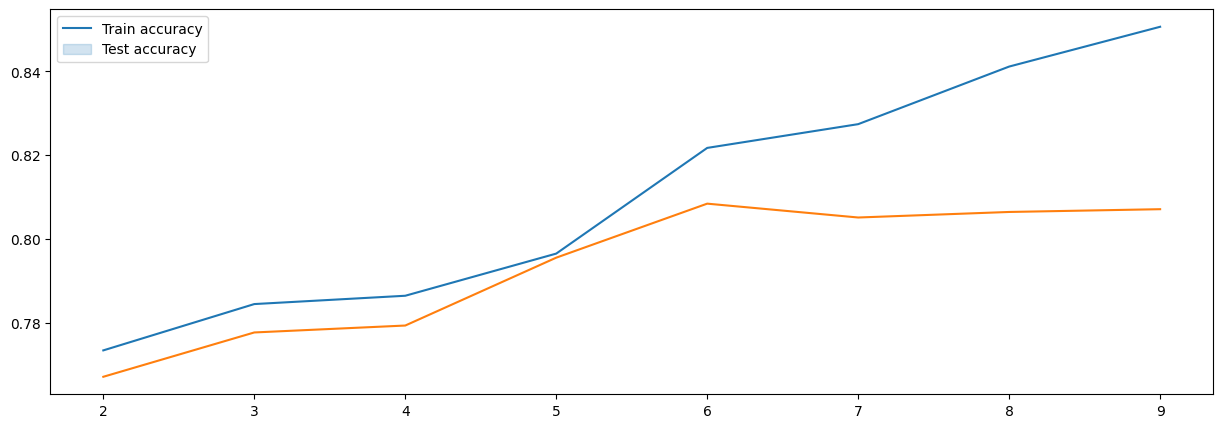

In [32]:
# Создадим словари, в которые мы будем помещать результаты вычисления accuracy
train_accuracy = {}
test_accuracy = {}

# Пройдемся по циклу и вычислим метрику для разной глубины дерева, результаты поместим в словарь
for i in range(2, 10):
    dt = tree.DecisionTreeClassifier(max_depth=i, random_state=42)
    dt.fit(X_train, y_train)
    y_pred_tr = dt.predict(X_train)
    train_accuracy[i] = metrics.accuracy_score(y_train, y_pred_tr)
    y_pred_te = dt.predict(X_test)
    test_accuracy[i] = metrics.accuracy_score(y_test, y_pred_te)
    
# Приведем словари к типу Series
train_accuracy = pd.Series(train_accuracy)
test_accuracy = pd.Series(test_accuracy)

# Визуализируем зависимость
fig = plt.figure(figsize=(15, 5))
sns.lineplot(x=train_accuracy.index, y=train_accuracy.values)
sns.lineplot(x=test_accuracy.index, y=test_accuracy.values)
plt.legend (('Train accuracy', 'Test accuracy'))

Как видим наиболее оптимальным является выбор дерева с максимальной глубиной 6.

Теперь попробуем улучшить метрику. Подберем гиперпараметры с помощью gridsearch, используя кросс-валидацию

In [55]:
from sklearn.model_selection import GridSearchCV

# Создаем объект класса решающее дерево
dt = tree.DecisionTreeClassifier(max_depth=6, random_state=42) 

# Инициализируем объект класса GridSearchCV
grid_search = GridSearchCV(
    estimator=dt, 
    param_grid={'min_samples_split': list(range(2, 9)),
                'criterion': ['gini', 'entropy']
                }, 
    cv=10,
    scoring='accuracy'
)  
# Обучаем и делаем предсказание
grid_search.fit(X_train, y_train)
y_pred_tr = grid_search.predict(X_train)
y_pred_te = grid_search.predict(X_test)

# Выводим метрики и лучшие значения гиперпараметров
print_metrics(y_pred_tr, y_pred_te)
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Accuracy на тренировочной выборке: 0.822
Accuracy на тестовой выборке: 0.808
f1-score на тренировочной выборке: 0.818
f1-score на тестовой выборке: 0.805
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'min_samples_split': 2}


Решающее дерево показало результат лучше чем логистическая регрессия. Сейчас можем перейти к более сложным моделям и попробовать улучшить результат.

# Часть 5: Ансамбли моделей и построение прогноза

Теперь попробуем обучить случайный лес и посмотрим какой результат он покажет. В данном случае думаю можно не ограничивать модель так сильно и выставить гиперпараметры чуть посвободнее, чем те которые мы получили для одного рещаюшего дерева.

In [34]:
# Создаем объект класса случайный лес и обучаем его
rf = ensemble.RandomForestClassifier(max_depth=8, min_samples_split=6, random_state=42)
rf.fit(X_train, y_train)

# Делаем предсказания
y_pred_tr = rf.predict(X_train)
y_pred_te = rf.predict(X_test)

# Выводим метрики
print_metrics(y_pred_tr, y_pred_te)

Accuracy на тренировочной выборке: 0.847
Accuracy на тестовой выборке: 0.825
f1-score на тренировочной выборке: 0.838
f1-score на тестовой выборке: 0.817


Нам уже удалось улучшить результат, но можно попробовать подобрать еще лучшие гиперпараметры. Попробуем это сделать при помощи optuna.

In [35]:
import optuna 
# Напишем функцию, которую будем максимизировать
def optuna_rf(trial):
  # Задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 4, 12, 1)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 10, 1)
  
  # Создаем модель
  rf = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_split=min_samples_split, 
                                          random_state=42
                                          )
  # Обучаем и делаем предсказание на тестовой выборке
  rf.fit(X_train, y_train)
  y_pred_te = rf.predict(X_test)
  
  # Возвращаем значение метрики f1
  return metrics.f1_score(y_test, y_pred_te)

# Создаем объект исследования, в котором укажем, что надо максимизировать метрику
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# Ищем лучшую комбинацию гиперпараметров, количество экспериментов ставим 20
study.optimize(optuna_rf, n_trials=20)

# Выводим результаты на тестовой выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на тестовом наборе: {:.3f}".format(study.best_value))

[I 2023-10-08 08:37:43,495] A new study created in memory with name: RandomForestClassifier
[I 2023-10-08 08:37:44,754] Trial 0 finished with value: 0.8165680473372782 and parameters: {'n_estimators': 189, 'max_depth': 9, 'min_samples_split': 2}. Best is trial 0 with value: 0.8165680473372782.
[I 2023-10-08 08:37:45,654] Trial 1 finished with value: 0.7961304192045862 and parameters: {'n_estimators': 175, 'max_depth': 5, 'min_samples_split': 8}. Best is trial 0 with value: 0.8165680473372782.
[I 2023-10-08 08:37:46,135] Trial 2 finished with value: 0.7988608045567818 and parameters: {'n_estimators': 104, 'max_depth': 5, 'min_samples_split': 4}. Best is trial 0 with value: 0.8165680473372782.
[I 2023-10-08 08:37:47,432] Trial 3 finished with value: 0.8186240444753301 and parameters: {'n_estimators': 147, 'max_depth': 9, 'min_samples_split': 2}. Best is trial 3 with value: 0.8186240444753301.
[I 2023-10-08 08:37:48,342] Trial 4 finished with value: 0.8119089316987742 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 119, 'max_depth': 10, 'min_samples_split': 8}
f1_score на тестовом наборе: 0.822


Посмотрим на метрики с подобранными гиперпараметрами:

In [43]:
# Создаем объект класса случайный лес и обучаем его
rf = ensemble.RandomForestClassifier(n_estimators=119, max_depth=10, min_samples_split=8, random_state=42)
rf.fit(X_train, y_train)

# Делаем предсказания
y_pred_tr = rf.predict(X_train)
y_pred_te = rf.predict(X_test)

# Выводим метрики
print_metrics(y_pred_tr, y_pred_te)

Accuracy на тренировочной выборке: 0.856
Accuracy на тестовой выборке: 0.83
f1-score на тренировочной выборке: 0.848
f1-score на тестовой выборке: 0.822


Подбор помог улучшить результат, при этом модель не усложнилась и не переобучилась.

Посмотрим какой результат выдаст модель градиентного бустинга. Возьмем модель со стандартными настройками гиперпараметров.

In [44]:
# Создаем объект класса градиентный бустинг и обучаем его
gb = ensemble.GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# Делаем предсказания
y_pred_tr = gb.predict(X_train)
y_pred_te = gb.predict(X_test)

# Выводим метрики
print_metrics(y_pred_tr, y_pred_te)

Accuracy на тренировочной выборке: 0.841
Accuracy на тестовой выборке: 0.827
f1-score на тренировочной выборке: 0.83
f1-score на тестовой выборке: 0.816


Теперь попробуем улучшить метрики, подобрав гиперпараметры.

In [45]:
def optuna_gb(trial):
  # Задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 2, 6, 1)
  learning_rate = trial.suggest_float(name='learning_rate', low=0.05, high=0.15, step=0.01)
  
  # Создаем модель
  gb = ensemble.GradientBoostingClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          learning_rate=learning_rate, 
                                          random_state=42
                                          )
  # Обучаем и делаем предсказание на тестовой выборке
  gb.fit(X_train, y_train)
  y_pred_te = rf.predict(X_test)
  
  # Возвращаем значение метрики f1
  return metrics.f1_score(y_test, y_pred_te)

# Создаем объект исследования, в котором укажем, что надо максимизировать метрику
study = optuna.create_study(study_name="GradientBoostingClassifier", direction="maximize")
# Ищем лучшую комбинацию гиперпараметров, количество экспериментов ставим 20
study.optimize(optuna_gb, n_trials=20)

# Выводим результаты на тестовой выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на тестовом наборе: {:.3f}".format(study.best_value))

[I 2023-10-08 08:40:06,136] A new study created in memory with name: GradientBoostingClassifier
[I 2023-10-08 08:40:08,011] Trial 0 finished with value: 0.8219840995506394 and parameters: {'n_estimators': 192, 'max_depth': 3, 'learning_rate': 0.09}. Best is trial 0 with value: 0.8219840995506394.
[I 2023-10-08 08:40:09,102] Trial 1 finished with value: 0.8219840995506394 and parameters: {'n_estimators': 105, 'max_depth': 3, 'learning_rate': 0.060000000000000005}. Best is trial 0 with value: 0.8219840995506394.
[I 2023-10-08 08:40:10,569] Trial 2 finished with value: 0.8219840995506394 and parameters: {'n_estimators': 110, 'max_depth': 4, 'learning_rate': 0.08}. Best is trial 0 with value: 0.8219840995506394.
[I 2023-10-08 08:40:12,363] Trial 3 finished with value: 0.8219840995506394 and parameters: {'n_estimators': 190, 'max_depth': 3, 'learning_rate': 0.11}. Best is trial 0 with value: 0.8219840995506394.
[I 2023-10-08 08:40:14,241] Trial 4 finished with value: 0.8219840995506394 and 

Наилучшие значения гиперпараметров {'n_estimators': 192, 'max_depth': 3, 'learning_rate': 0.09}
f1_score на тестовом наборе: 0.822


Построим модель с подобранными параметрами и выведем результат.

In [46]:
# Создаем объект класса градиентный бустинг и обучаем его
gb = ensemble.GradientBoostingClassifier(
    n_estimators=192,
    max_depth=3,
    learning_rate=0.09,                     
    random_state=42
    )
gb.fit(X_train, y_train)

# Делаем предсказания
y_pred_tr = gb.predict(X_train)
y_pred_te = gb.predict(X_test)

# Выводим метрики
print_metrics(y_pred_tr, y_pred_te)

Accuracy на тренировочной выборке: 0.849
Accuracy на тестовой выборке: 0.829
f1-score на тренировочной выборке: 0.84
f1-score на тестовой выборке: 0.82


Метрики улучшились и при этом мы не усложнили и не переобучили модель. В целом можно сказать. что результат градиентного бустинга практически идентичен случайному лесу.

Теперь применим стэкинг и посмотрим какой получится результат.

In [53]:
# Создаем список моделей
estimators = [
    ('dt', tree.DecisionTreeClassifier( 
                                       random_state=42, 
                                       max_depth=6,
                                       min_samples_split=2
                                       )
     ),
    ('gb', ensemble.GradientBoostingClassifier( 
                                                learning_rate=0.09,
                                                max_depth=3, 
                                                n_estimators=192, 
                                                random_state=42
                                                )
     ),
    ('rf', ensemble.RandomForestClassifier(
                                            n_estimators=119,
                                            max_depth=10,
                                            min_samples_split=8,
                                            random_state=42
                                            )
     ),
    ('lr', linear_model.LogisticRegression(random_state=42))
]

# Создаем объект класса стекинг и обучаем модель
sr = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
sr.fit(X_train, y_train)

# Делаем предсказания
y_pred_tr = sr.predict(X_train)
y_pred_te = sr.predict(X_test)

# Выводим метрики
print_metrics(y_pred_tr, y_pred_te)

Accuracy на тренировочной выборке: 0.848
Accuracy на тестовой выборке: 0.828
f1-score на тренировочной выборке: 0.837
f1-score на тестовой выборке: 0.817


Несмотря на усложнение модели, нам не удалось улучшить результат. Таким образом наилучшей моделью, показавшей себя в данной задаче оказался случайный лес.

Посмотрим еще на один график, он показывает насколько важен вклад каждого признака в итоговый результат для дерева решений.

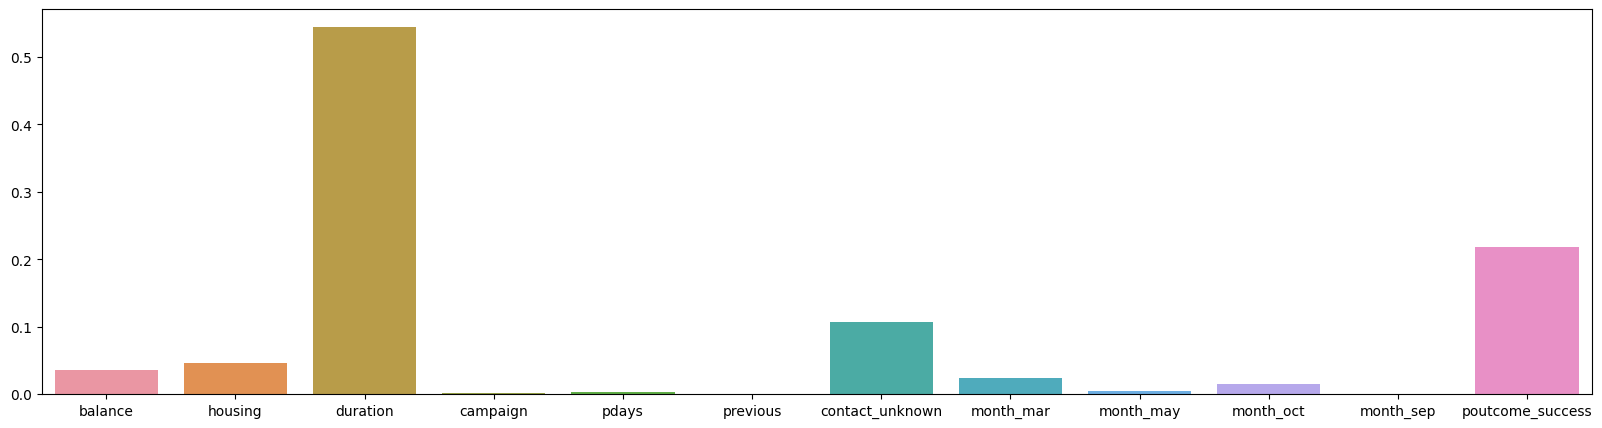

In [70]:
# Создаем модель и обучаем ее
dt = tree.DecisionTreeClassifier(random_state=42, max_depth=6, min_samples_split=2)
dt.fit(X_train, y_train)

# Построим график: по оси х названия колонок, а по у значимость признака, выданная деревом
fig = plt.figure(figsize=(20, 5))
sns.barplot(x=X.columns, y=dt.feature_importances_);

Вывод:
---

Как мы видим по графику выше, да и по предыдущим графикам, львиную долю влияния на решение об открытии депозита производит длительность звонка и результат прошлой рекламной кампании. Если разговор короткий, то значит клиент не заинтересован в услугах банка, соответственно результат этого звонка будет отрицательным. И чем длиннее звонок, тем больше вероятность открыть депозит. В то же время если клиент уже соглашался на предложение какого-либо продукта банком, то и вероятность добиться успеха в текущей кампании значительно выше.